### Генерация аккордов в последовательности

Задание заключается в написании модели BERT для генерации гитарных аккордов.

В качестве данных взят датасет https://huggingface.co/datasets/lluccardoner/melodyGPT-song-chords-text-1.

В этом ноутбуке присутствует:

1) Очистка данных 

2) Аугментация

3) Токенизатор

4) Обучение модели

In [1]:
# !pip install transformers datasets torch scikit-learn matplotlib seaborn streamlit plotly

In [2]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from tqdm import tqdm
import re
from typing import List, Tuple, Optional, Mapping,  Self, NamedTuple
import pandas as pd
from datasets import load_dataset
import ast
import itertools
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertForMaskedLM
warnings.filterwarnings('ignore')


In [3]:
def load_and_clean_dataset():

    dataset = load_dataset("lluccardoner/melodyGPT-song-chords-text-1")
    df = dataset['train'].to_pandas()

    def clean_chords(text):
        if not isinstance(text, str):
            return ""

        text = re.sub(r'\t', ' ', text)
        text = re.sub(r'\b(INTRO|VERSE|CHORUS|BRIDGE|OUTRO|SOLO|PRE-CHORUS)\b', '', text, flags=re.IGNORECASE)
        chords = re.findall(r'[A-G][#b]?(?:m)?(?:1[0-3]|[2-9])?', text)

        return ' '.join(chords)

    df['cleaned_chords'] = df['chords_str'].apply(clean_chords)

    df = df[df['cleaned_chords'].str.len() > 0]

    return df


class ChordTransposer:

    def __init__(self):
        self.chord_map = {
            'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3,
            'E': 4, 'F': 5, 'F#': 6, 'Gb': 6, 'G': 7, 'G#': 8,
            'Ab': 8, 'A': 9, 'A#': 10, 'Bb': 10, 'B': 11
        }
        self.reverse_map = {v: k for k, v in self.chord_map.items()}

        self.chord_patterns = [
            # Аккорды с add: Cadd9, Dmadd11
            #r'([A-G][#b]?)(.*)(add.*)',
            # Септаккорды и расширения: Cmaj7, G9, Am11
            r'([A-G][#b]?)(.*)(\d+)',
            # Базовые аккорды: C, Dm, E7
            r'([A-G][#b]?)(.*)'
        ]

    def transpose_chord(self, chord, steps):

        for pattern in self.chord_patterns:
            match = re.match(pattern, chord)
            if match:
                groups = match.groups()
                tone = groups[0]

                if tone in self.chord_map:

                    new_tone_num = (self.chord_map[tone] + steps) % 12
                    new_tone = self.reverse_map[new_tone_num]

                    if len(groups) == 3:
                        quality = groups[1] or ''
                        extension = groups[2] or ''
                        return new_tone + quality + extension
                    else:
                        quality = groups[1] or ''
                        return new_tone + quality

                break

        return chord

    def transpose_sequence(self, chord_sequence, steps):
        chords = chord_sequence.split()
        transposed = [self.transpose_chord(chord, steps) for chord in chords]
        return ' '.join(transposed)

def augment_dataset(df, num_transpositions=5):
    transposer = ChordTransposer()
    augmented_data = []

    for _, row in df.iterrows():
        chords = row['cleaned_chords']
        if len(chords.split()) < 3:
            continue

        augmented_data.append({
            'cleaned_chords': chords,
            'genres': row.get('genres'),
            'artist_name': row.get('artist_name', 'unknown'),
            'song_name': row.get('song_name', 'unknown')
        })

        for steps in range(1, num_transpositions + 1):
            transposed = transposer.transpose_sequence(chords, steps)
            augmented_data.append({
                'cleaned_chords': transposed,
                'genres': row.get('genres'),
                'artist_name': row.get('artist_name', 'unknown'),
                'song_name': row.get('song_name', 'unknown')
            })

    return pd.DataFrame(augmented_data)

In [4]:
dataset = load_and_clean_dataset()

In [5]:
list_cleaned_chords = dataset['cleaned_chords'].map(lambda x: x.split(' '))

chords_set = set()
for row in list_cleaned_chords:
  chords_set.update(row)

In [6]:
unique_genres = [ast.literal_eval(i) for i in dataset.genres.values]
unique_genres = list(itertools.chain(*unique_genres))
unique_genres = set(unique_genres)

Тут выделили 15 жанров

In [7]:
CATEGORY_KEYWORDS = {
    "rock": [
        "rock", "punk", "grunge", "garage", "metalcore", "post-hardcore", "post-rock",
        "thrash", "mathcore", "emo", "hard rock", "alternative", "indie rock",
        "psychedelic", "rockabilly", "southern rock", "gothic", "industrial rock",
        "progressive rock", "metal", "doom", "americana", "folk rock", "country rock"
    ],
    "pop": [
        "pop", "idol", "dance", "electropop", "teen", "bubblegum", "k-pop", "j-pop",
        "torch song", "synthpop", "mandopop", "channel pop", "viral pop", "social media pop",
        "pop rock", "pop punk", "boy group", "girl group", "catchy", "telepop", "uk dance", 'indie'
    ],
    "hip hop / rap": [
        "hip hop", "rap", "trap", "drill", "boom bap", "gangsta", "underground rap",
        "latin rap", "rap baiano", "rap francais", "rap consciente", "rap cristiano",
        "rap urbano", "rap napoletano", "rap mineiro", "rap mexicano", "rap argentino",
        "east coast rap", "west coast rap", "st louis rap", "experimental hip hop"
    ],
    "metal": [
        "metal", "black metal", "death metal", "power metal", "doom", "melodic metal",
        "metalcore", "mathcore", "symphonic metal", "progressive metal", "thrash metal",
        "industrial metal", "gothic metal", "melodic hardcore"
    ],
    "electronic / edm": [
        "edm", "electro", "house", "trance", "techno", "dubstep", "drum and bass",
        "idm", "electronica", "chiptune", "bmore", "downtempo", "future bass",
        "future house", "progressive house", "deep house", "nu disco", "synthwave",
        "vaporwave", "electro-pop", "electropowerpop", "tech house", "minimal techno",
        "classic dubstep", "german trance", "electronic", 'flow', 'disco', 'bounce', 'new beat', 'wave'
    ],
    "jazz / blues": [
        "jazz", "blues", "bebop", "swing", "fusion", "big band", "cool jazz", "smooth jazz",
        "vocal jazz", "jazz trio", "jazz rock", "jazz funk", "jazz piano", "jazz guitar",
        "jazz saxophone", "jazz trumpet", "jazz vibraphone"
    ],
    "folk / country": [
        "folk", "americana", "country", "bluegrass", "roots", "celtic", "rondoniense",
        "american", "traditional", "folk-pop", "folk rock", "country rock", "indie folk",
        "world folk", "native american", "scottish folk", "norwegian folk",
        "argentine folklore", "mexican folklore", "brazilian folk", "musica rondoniense",
        "country pop", 'carnavalera', 'nashville sound', 'irish'
    ],
    "latin / world": [
        "latin", "reggaeton", "salsa", "afrobeat", "world", "bossa", "cumbia", "mariachi",
        "vallenato", "bachata", "forro", "tango", "merengue", "samba", "musica",
        "caribbean", "african", "brazilian", "argentine", "peruvian", "dominican",
        "latin rock", "argentine telepop", "musica paranaense", 'reggae', 'venezuelan', 'murcia', 'bollywood'
    ],
    "classical": [
        "classical", "orchestra", "baroque", "opera", "symphonic", "romantic",
        "impressionism", "chamber", "early music", "tenor", "soprano", "mandolin",
        "classical era", "classical performance", "brega romantico", 'choral'
    ],
    "r&b / soul": [
        "r&b", "soul", "funk", "motown", "neo soul", "alternative r&b", "quiet storm",
        "chill r&b", "groove gospel", "urban contemporary", "soul blues", "vocal harmony",
        "scandinavian r&b", "experimental r&b"
    ],
    "punk / hardcore": [
        "punk", "hardcore", "ska", "oi!", "anarcho", "hardcore punk", "post-punk",
        "pop punk", "garage punk", "street punk", "emo", "grindcore", "early us punk",
        "psychedelic punk"
    ],
    "religious / worship": [
        "christian", "worship", "gospel", "adoracao", "sholawat", "nasheed", "louvor",
        "lds", "spirituals", "chant", "kirtan", "uvielbienie", "groove gospel", 'choral'
    ],
    "soundtrack / score / instrumental": [
        "soundtrack", "score", "instrumental", "video game music", "orchestral",
        "meditation", "theme", "film", "game", "anime score", "classify", 'movie', 'tunes'
    ],
    "children / family": ["children's music", "kindermusik", "barnemusikk", "barnmusik",
                          "kids", "nursery rhymes", "lullaby", "kids songs", "children's choir",
                          "children's folk", "musica infantil", "baby music", "kids pop", "kids edm"],
    "other / misc": [
        "comedia", "comic", "uwielbienie", "singaporean singer-songwriter", "seattle indie",
        "lagu jawa", "chinese audiophile", "gruperas inmortales", "banda carnavalera"
    ]
}

# жанр может принадлежать сразу к нескольким категориям
def map_genres_to_categories(genre_list):
    # Если это строка, превращаем в список
    if isinstance(genre_list, str):
        genre_list = [g.strip() for g in genre_list.split(",")]

    matched_categories = set()

    for genre in genre_list:
        genre_lower = genre.lower()  # работаем с жанром как строкой
        for category, keywords in CATEGORY_KEYWORDS.items():
            for kw in keywords:
                if kw in genre_lower:
                    matched_categories.add(category)

    if not matched_categories:
        matched_categories.add("other / misc")

    return list(matched_categories)[0]

# Создание маппинга всех жанров
genre_mapping = {g: map_genres_to_categories(g) for g in unique_genres}

In [8]:
dataset["main_categories"] = dataset["genres"].apply(map_genres_to_categories)

In [9]:
cats_dict = {c:i for i,c in enumerate(dataset['main_categories'].unique())}
dataset['map_main_cats'] = dataset['main_categories'].apply(lambda x: cats_dict.get(x))

In [87]:
import pickle

with open('cats_dict_mapping.pickle', 'wb') as file:
    pickle.dump(cats_dict, file)

Аугментированный датасет, для обучения берется обычный датасет

In [10]:
# augmented_dataset = augment_dataset(dataset)

### Токенайзер

In [ ]:
class ChordTokenizer:
    def __init__(self, chords_set, vocab_file=None):


        self.special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']

        self.vocab = {token: idx for idx, token in enumerate(self.special_tokens)}

        for idx, element in enumerate(chords_set):
            self.vocab[element] = len(self.vocab)


        self.reverse_vocab = {v: k for k, v in self.vocab.items()}

    def tokenize(self, text):
        chords = text.split(' ')

        tokens = []

        for chord in chords:
            tokens.append(chord)

        if tokens and tokens[-1] == ' ':
            tokens.pop()

        return tokens

    def convert_tokens_to_ids(self, tokens):
        return [self.vocab.get(token, self.vocab['[UNK]']) for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self.reverse_vocab.get(id, '[UNK]') for id in ids]

    def __len__(self):
        return len(self.vocab)

class ChordTokenizerHF:
    def __init__(self, chord_tokenizer):
        self.chord_tokenizer = chord_tokenizer

    def __call__(self, texts, padding=True, truncation=True, max_length=50, return_tensors=None):
        if isinstance(texts, str):
            texts = [texts]

        input_ids = []
        attention_masks = []

        for text in texts:
            tokens = self.chord_tokenizer.tokenize(text)
            token_ids = self.chord_tokenizer.convert_tokens_to_ids(tokens)

            if len(token_ids) > max_length:
                token_ids = token_ids[:max_length]

            attention_mask = [1] * len(token_ids)

            if padding:
                padding_length = max_length - len(token_ids)
                token_ids = token_ids + [self.chord_tokenizer.vocab['[PAD]']] * padding_length
                attention_mask = attention_mask + [0] * padding_length

            input_ids.append(token_ids)
            attention_masks.append(attention_mask)

        output = {
            'input_ids': torch.tensor(input_ids) if return_tensors == 'pt' else input_ids,
            'attention_mask': torch.tensor(attention_masks) if return_tensors == 'pt' else attention_masks
        }

        return output

Обучаем токенайзер

In [12]:
class TrainingBatch(NamedTuple):
    input: torch.LongTensor
    attention_mask: torch.LongTensor
    label: torch.LongTensor
    genre_label: torch.LongTensor

In [13]:
class ChordDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=50, mask_probability=0.15, add_cls_for_genre=False, genre_labels=None):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_probability = mask_probability
        self.add_cls_for_genre = add_cls_for_genre
        self.genre_labels = genre_labels
        

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        
        if self.add_cls_for_genre:
            text = "[CLS] " + text

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        labels = input_ids.clone()

        rand = torch.rand(input_ids.shape)
        mask_arr = (rand < self.mask_probability) * (input_ids != self.tokenizer.chord_tokenizer.vocab['[PAD]'])
        
        if self.add_cls_for_genre:
            cls_token_id = self.tokenizer.chord_tokenizer.vocab['[CLS]']
            mask_arr = mask_arr * (input_ids != cls_token_id)

        for i in range(input_ids.shape[0]):
            if mask_arr[i]:
                input_ids[i] = self.tokenizer.chord_tokenizer.vocab['[MASK]']

        return_dict = {
            'input': torch.LongTensor(input_ids),
            'attention_mask': torch.LongTensor(attention_mask),
            'label': torch.LongTensor(labels),
        }
        
        if self.add_cls_for_genre:
            return_dict['genre_label'] = torch.LongTensor([self.genre_labels[idx]])
            
        return TrainingBatch(**return_dict)

In [14]:
chord_tokenizer = ChordTokenizer(chords_set)
hf_tokenizer = ChordTokenizerHF(chord_tokenizer)

data = ChordDataset(dataset['cleaned_chords'].tolist(), hf_tokenizer, add_cls_for_genre=True, genre_labels=dataset['map_main_cats'].tolist())

In [ ]:
class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size: int, embedding_size: int, max_seq_len: int = 512, dropout: float = 0.1):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(max_seq_len, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embedding_size)
        
    def forward(self, x: torch.LongTensor) -> torch.Tensor:
        seq_len = x.size(1)
        positions = torch.arange(seq_len, dtype=torch.long, device=x.device).unsqueeze(0)
        
        token_emb = self.token_embeddings(x)
        position_emb = self.position_embeddings(positions)
        
        embeddings = token_emb + position_emb
        return self.dropout(self.layer_norm(embeddings))

In [16]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, num_heads: int, embedding_size: int, dropout: float = 0.1):
        super().__init__()
        assert embedding_size % num_heads == 0
        self.num_heads = num_heads
        self.head_size = embedding_size // num_heads
        self.embedding_size = embedding_size
        
        self.q_linear = nn.Linear(embedding_size, embedding_size)
        self.k_linear = nn.Linear(embedding_size, embedding_size)
        self.v_linear = nn.Linear(embedding_size, embedding_size)
        self.out_linear = nn.Linear(embedding_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embedding_size)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size, seq_len = x.size(0), x.size(1)
        
        # Linear projections
        q = self.q_linear(x).view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        k = self.k_linear(x).view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        v = self.v_linear(x).view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        
        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_size)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Softmax and attention
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, v)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embedding_size)
        
        output = self.out_linear(context)
        return self.layer_norm(x + self.dropout(output))

In [17]:
class FCNNBlock(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        hidden_size: int,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()
        self._linear1 = nn.Linear(embedding_size, hidden_size, bias=False)
        self._linear2 = nn.Linear(hidden_size, embedding_size, bias=False)
        self._activation = nn.GELU()
        self._layernorm = nn.LayerNorm(embedding_size)
        self._dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self._linear2(self._activation(self._linear1(x)))
        return self._layernorm(x + self._dropout(z))


class EncoderLayer(nn.Module):
    def __init__(self, embedding_size: int, num_heads: int, fcnn_hidden_size: int, dropout: float = 0.1):
        super().__init__()
        self.attention = MultiHeadedAttention(num_heads, embedding_size, dropout)
        self.fcnn = FCNNBlock(embedding_size, fcnn_hidden_size, dropout)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = self.attention(x, mask)
        return self.fcnn(x)

class Encoder(nn.Module):
    def __init__(self, vocab_size: int, n_layers: int, embedding_size: int, 
                 num_heads: int, fcnn_hidden_size: int, max_seq_len: int = 512, dropout: float = 0.1):
        super().__init__()
        self._embedding_size = embedding_size
        self._vocab_size = vocab_size
        
        self.embeddings = BERTEmbedding(vocab_size, embedding_size, max_seq_len, dropout)
        self.layers = nn.ModuleList([
            EncoderLayer(embedding_size, num_heads, fcnn_hidden_size, dropout)
            for _ in range(n_layers)
        ])
    
    @property
    def embedding_size(self) -> int:
        return self._embedding_size
    
    @property
    def vocab_size(self) -> int:
        return self._vocab_size
        
    def forward(self, x: torch.LongTensor):
        mask = (x != 0).unsqueeze(1).unsqueeze(2)
        x = self.embeddings(x)
        
        for layer in self.layers:
            x = layer(x, mask)
            
        return x

In [18]:
class MaskedLanguageModel(nn.Module):
    def __init__(self, embedding_size: int, vocab_size: int):
        super().__init__()
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        return self.linear(x) 

In [19]:
from torch.optim.lr_scheduler import LambdaLR

def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch=last_epoch)

In [ ]:
VOCAB_SIZE = len(chord_tokenizer.vocab)
BATCH_SIZE = 64  
MAX_SEQ_LEN = 50 
N_LAYERS = 4 
EMBEDDING_SIZE = 256  
NUM_HEADS = 8
HEAD_EMBEDDING_SIZE = EMBEDDING_SIZE // NUM_HEADS 
FCCN_HIDDEN_SIZE = 512
DROPOUT = 0.2

n_epoch = 5 

In [21]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


def split_dataset(dataset, test_size=0.1, random_state=42):
    indices = list(range(len(dataset)))
    train_idx, val_idx = train_test_split(
        indices, test_size=test_size, random_state=random_state
    )
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

train_dataset, val_dataset = split_dataset(data)
train_chord = train_dataset.dataset
val_chord = val_dataset.dataset

In [22]:
def collate(batch):
    """Collate function для создания батчей"""
    inputs = torch.stack([item.input for item in batch])
    labels = torch.stack([item.label for item in batch])
    attention_mask = torch.stack([item.attention_mask for item in batch])
    genre_label = torch.stack([item.genre_label for item in batch])

    return TrainingBatch(
        input=inputs,
        attention_mask=attention_mask,
        label=labels,
        genre_label=genre_label
    )

In [23]:
train_dataloader = DataLoader(
    dataset=train_chord,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate
)

val_dataloader = DataLoader(
    dataset=val_chord,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate
)

In [24]:
batch = next(iter(train_dataloader))

In [25]:
encoder = Encoder(
    vocab_size=VOCAB_SIZE,
    n_layers=N_LAYERS,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    fcnn_hidden_size=FCCN_HIDDEN_SIZE,
    dropout=DROPOUT
)

In [31]:
class BERTLM_MLM_And_Genre(nn.Module):
    def __init__(self, encoder: Encoder, num_genres: int):
        super().__init__()
        self._encoder = encoder
        self._mask_lm = MaskedLanguageModel(self._encoder.embedding_size, self._encoder.vocab_size)
        self._genre_classifier = nn.Linear(self._encoder.embedding_size, num_genres)
        
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, x: torch.LongTensor, return_genre_pred: bool = False):
        encoder_output = self._encoder(x)
        
        mlm_output = self._mask_lm(encoder_output)
        
        if return_genre_pred:
            cls_output = encoder_output[:, 0, :]
            genre_output = self._genre_classifier(cls_output)
            return mlm_output, genre_output
        else:
            return mlm_output

In [34]:
dataset.main_categories.nunique()

15

In [35]:
mlm_model = BERTLM_MLM_And_Genre(encoder, num_genres = dataset.main_categories.nunique())

Сначала будем учить MLM

In [36]:
import logging
import os
from datetime import datetime

class MLM_Trainer:
    def __init__(self, model, train_dataloader, val_dataloader=None, lr=1e-4, device='cuda', log_dir="training_logs"):
        self.device = device
        self.model = model.to(device)
        self.train_data = train_dataloader
        self.val_data = val_dataloader

        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(self.log_dir, f"mlm_training_{timestamp}.log")
        
        self._setup_logging()
        
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01
        )
        additional_epochs = 31
        total_steps = len(train_dataloader) * additional_epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=total_steps // 10, 
            num_training_steps=total_steps
        )
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
        
        self.logger.info("MLM_Trainer initialized")
        self.logger.info(f"Device: {device}, Learning rate: {lr}")
        self.logger.info(f"Train batches: {len(train_dataloader)}, Val batches: {len(val_dataloader) if val_dataloader else 0}")
        self.logger.info(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    def _setup_logging(self):
        self.logger = logging.getLogger('MLM_Trainer')
        self.logger.setLevel(logging.DEBUG)
        
        if self.logger.handlers:
            self.logger.handlers.clear()
        
        formatter = logging.Formatter(
            '%(asctime)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )
        
        file_handler = logging.FileHandler(self.log_file, encoding='utf-8')
        file_handler.setLevel(logging.DEBUG)
        file_handler.setFormatter(formatter)
        
        console_handler = logging.StreamHandler()
        console_handler.setLevel(logging.INFO)
        console_handler.setFormatter(formatter)
        
        self.logger.addHandler(file_handler)
        self.logger.addHandler(console_handler)
        
        self.logger.info(f"Logging initialized. Log file: {self.log_file}")
    
    def train_epoch(self, epoch: int):
        self.model.train()
        total_loss = 0.0
        total_mlm_correct = 0
        total_mlm_elements = 0
        
        self.logger.info(f"Starting epoch {epoch}")
        self.logger.info(f"{'='*50}")
        
        for i, batch in enumerate(tqdm(self.train_data)):
            inputs = batch.input.to(self.device)
            labels = batch.label.to(self.device)
            
            self.optimizer.zero_grad()
            
            mlm_output = self.model(inputs)
            
            mlm_loss = self.criterion(
                mlm_output.view(-1, mlm_output.size(-1)),
                labels.view(-1)
            )
            
            mlm_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()
            
            total_loss += mlm_loss.item()
            
            with torch.no_grad():
                mlm_pred = mlm_output.argmax(dim=-1)
                mask_token_id = 4 
                mask_positions = (inputs == mask_token_id) & (labels != 0)
                if mask_positions.any():
                    mlm_correct = (mlm_pred[mask_positions] == labels[mask_positions]).sum().item()
                    total_mlm_correct += mlm_correct
                    total_mlm_elements += mask_positions.sum().item()
            
            if i % 100 == 0:
                avg_loss = total_loss / (i + 1)
                mlm_acc = total_mlm_correct / total_mlm_elements if total_mlm_elements > 0 else 0
                current_lr = self.optimizer.param_groups[0]['lr']
                
                self.logger.info(f"Batch {i}: Loss: {avg_loss:.4f}, MLM Acc: {mlm_acc:.4f}, LR: {current_lr:.2e}")
                
                if i % 500 == 0:
                    self.logger.debug(f"Batch {i} detailed - Loss: {mlm_loss.item():.4f}, "
                                    f"Masked tokens: {mask_positions.sum().item()}")
        
        epoch_avg_loss = total_loss / len(self.train_data)
        final_mlm_acc = total_mlm_correct / total_mlm_elements if total_mlm_elements > 0 else 0
        
        self.logger.info(f"Epoch {epoch} completed")
        self.logger.info(f"Epoch {epoch} - Average Loss: {epoch_avg_loss:.4f}, Final MLM Accuracy: {final_mlm_acc:.4f}")
        self.logger.info(f"{'='*50}")
        
        return epoch_avg_loss
    
    def validate(self, epoch: int):
        if self.val_data is None:
            self.logger.warning("No validation data provided")
            return None
            
        self.model.eval()
        total_val_loss = 0.0
        total_val_mlm_correct = 0
        total_val_mlm_elements = 0
        
        self.logger.info(f"Starting validation for epoch {epoch}")
        
        with torch.no_grad():
            for batch in self.val_data:
                inputs = batch.input.to(self.device)
                labels = batch.label.to(self.device)
                
                mlm_output = self.model(inputs)
                
                mlm_loss = self.criterion(
                    mlm_output.view(-1, mlm_output.size(-1)),
                    labels.view(-1)
                )
                
                total_val_loss += mlm_loss.item()
                
                mlm_pred = mlm_output.argmax(dim=-1)
                mask_token_id = 4
                mask_positions = (inputs == mask_token_id) & (labels != 0)
                if mask_positions.any():
                    mlm_correct = (mlm_pred[mask_positions] == labels[mask_positions]).sum().item()
                    total_val_mlm_correct += mlm_correct
                    total_val_mlm_elements += mask_positions.sum().item()
        
        avg_val_loss = total_val_loss / len(self.val_data)
        val_mlm_acc = total_val_mlm_correct / total_val_mlm_elements if total_val_mlm_elements > 0 else 0
        
        self.logger.info(f"Validation Epoch {epoch} - Loss: {avg_val_loss:.4f}, MLM Acc: {val_mlm_acc:.4f}")
        self.logger.info(f"Validation details - Correct: {total_val_mlm_correct}, Total masked: {total_val_mlm_elements}")
        
        return avg_val_loss

In [38]:
device = "cuda:0"
mlmbert_trainer = MLM_Trainer(
    model=mlm_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr=1e-4,
    device=device,
)

2025-11-29 03:47:14 - INFO - Logging initialized. Log file: training_logs/mlm_training_20251129_034714.log
2025-11-29 03:47:14 - INFO - MLM_Trainer initialized
2025-11-29 03:47:14 - INFO - Device: cuda:0, Learning rate: 0.0001
2025-11-29 03:47:14 - INFO - Train batches: 2108, Val batches: 2108
2025-11-29 03:47:14 - INFO - Model parameters: 2,410,586


In [39]:
n_epoch = 30
best_val_loss = float('inf')
save_path = 'correct_best_mlmbert_model_10epochs.pth'

print("Starting MLM BERT training...")
print(f"Will save best model to: {save_path}")

for epoch in range(n_epoch + 1):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch}/{n_epoch}")
    print(f"{'='*50}")
    
    train_loss = mlmbert_trainer.train_epoch(epoch)
    
    val_loss = mlmbert_trainer.validate(epoch)
    
    if val_loss is not None and val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': mlmbert_trainer.model.state_dict(),
            'optimizer_state_dict': mlmbert_trainer.optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss,
        }, save_path)
        print(f"Saved best model with val_loss: {val_loss:.4f}")
    else:
        print(f"Current best val_loss: {best_val_loss:.4f}")
    
    checkpoint_path = f'checkpoints_30/checkpoint_epoch_{epoch}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': mlmbert_trainer.model.state_dict(),
        'optimizer_state_dict': mlmbert_trainer.optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss if val_loss is not None else train_loss,
        'best_val_loss': best_val_loss,
    }, checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")

2025-11-29 03:47:16 - INFO - Starting epoch 0
2025-11-29 03:47:16 - INFO - ==================================================


Starting MLM BERT training...
Will save best model to: correct_best_mlmbert_model_10epochs.pth

Epoch 0/30


100%|██████████| 2108/2108 [00:42<00:00, 49.96it/s]
2025-11-29 03:47:58 - INFO - Epoch 0 completed
2025-11-29 03:47:58 - INFO - Epoch 0 - Average Loss: 1.5160, Final MLM Accuracy: 0.2078
2025-11-29 03:47:58 - INFO - ==================================================
2025-11-29 03:47:58 - INFO - Starting validation for epoch 0
2025-11-29 03:48:18 - INFO - Validation Epoch 0 - Loss: 0.3415, MLM Acc: 0.2544
2025-11-29 03:48:18 - INFO - Validation details - Correct: 224548, Total masked: 882602
2025-11-29 03:48:18 - INFO - Starting epoch 1
2025-11-29 03:48:18 - INFO - ==================================================


Saved best model with val_loss: 0.3415
Saved checkpoint: checkpoints_30/checkpoint_epoch_0.pth

Epoch 1/30


100%|██████████| 2108/2108 [00:43<00:00, 48.96it/s]
2025-11-29 03:49:01 - INFO - Epoch 1 completed
2025-11-29 03:49:01 - INFO - Epoch 1 - Average Loss: 0.3424, Final MLM Accuracy: 0.2469
2025-11-29 03:49:01 - INFO - ==================================================
2025-11-29 03:49:01 - INFO - Starting validation for epoch 1
2025-11-29 03:49:22 - INFO - Validation Epoch 1 - Loss: 0.3013, MLM Acc: 0.2501
2025-11-29 03:49:22 - INFO - Validation details - Correct: 220524, Total masked: 881766
2025-11-29 03:49:22 - INFO - Starting epoch 2
2025-11-29 03:49:22 - INFO - ==================================================


Saved best model with val_loss: 0.3013
Saved checkpoint: checkpoints_30/checkpoint_epoch_1.pth

Epoch 2/30


100%|██████████| 2108/2108 [00:44<00:00, 47.63it/s]
2025-11-29 03:50:06 - INFO - Epoch 2 completed
2025-11-29 03:50:06 - INFO - Epoch 2 - Average Loss: 0.3113, Final MLM Accuracy: 0.2469
2025-11-29 03:50:06 - INFO - ==================================================
2025-11-29 03:50:06 - INFO - Starting validation for epoch 2
2025-11-29 03:50:27 - INFO - Validation Epoch 2 - Loss: 0.2936, MLM Acc: 0.2484
2025-11-29 03:50:27 - INFO - Validation details - Correct: 219360, Total masked: 882927
2025-11-29 03:50:27 - INFO - Starting epoch 3
2025-11-29 03:50:27 - INFO - ==================================================


Saved best model with val_loss: 0.2936
Saved checkpoint: checkpoints_30/checkpoint_epoch_2.pth

Epoch 3/30


100%|██████████| 2108/2108 [00:47<00:00, 44.77it/s]
2025-11-29 03:51:15 - INFO - Epoch 3 completed
2025-11-29 03:51:15 - INFO - Epoch 3 - Average Loss: 0.3003, Final MLM Accuracy: 0.2487
2025-11-29 03:51:15 - INFO - ==================================================
2025-11-29 03:51:15 - INFO - Starting validation for epoch 3
2025-11-29 03:51:39 - INFO - Validation Epoch 3 - Loss: 0.2887, MLM Acc: 0.2545
2025-11-29 03:51:39 - INFO - Validation details - Correct: 224791, Total masked: 883263
2025-11-29 03:51:39 - INFO - Starting epoch 4
2025-11-29 03:51:39 - INFO - ==================================================


Saved best model with val_loss: 0.2887
Saved checkpoint: checkpoints_30/checkpoint_epoch_3.pth

Epoch 4/30


100%|██████████| 2108/2108 [00:41<00:00, 50.47it/s]
2025-11-29 03:52:21 - INFO - Epoch 4 completed
2025-11-29 03:52:21 - INFO - Epoch 4 - Average Loss: 0.2945, Final MLM Accuracy: 0.2531
2025-11-29 03:52:21 - INFO - ==================================================
2025-11-29 03:52:21 - INFO - Starting validation for epoch 4
2025-11-29 03:52:39 - INFO - Validation Epoch 4 - Loss: 0.2856, MLM Acc: 0.2590
2025-11-29 03:52:39 - INFO - Validation details - Correct: 228449, Total masked: 881963
2025-11-29 03:52:39 - INFO - Starting epoch 5
2025-11-29 03:52:39 - INFO - ==================================================


Saved best model with val_loss: 0.2856
Saved checkpoint: checkpoints_30/checkpoint_epoch_4.pth

Epoch 5/30


100%|██████████| 2108/2108 [00:42<00:00, 50.10it/s]
2025-11-29 03:53:21 - INFO - Epoch 5 completed
2025-11-29 03:53:21 - INFO - Epoch 5 - Average Loss: 0.2918, Final MLM Accuracy: 0.2597
2025-11-29 03:53:21 - INFO - ==================================================
2025-11-29 03:53:21 - INFO - Starting validation for epoch 5
2025-11-29 03:53:43 - INFO - Validation Epoch 5 - Loss: 0.2818, MLM Acc: 0.2750
2025-11-29 03:53:43 - INFO - Validation details - Correct: 242692, Total masked: 882507
2025-11-29 03:53:43 - INFO - Starting epoch 6
2025-11-29 03:53:43 - INFO - ==================================================


Saved best model with val_loss: 0.2818
Saved checkpoint: checkpoints_30/checkpoint_epoch_5.pth

Epoch 6/30


100%|██████████| 2108/2108 [00:40<00:00, 52.55it/s]
2025-11-29 03:54:23 - INFO - Epoch 6 completed
2025-11-29 03:54:23 - INFO - Epoch 6 - Average Loss: 0.2852, Final MLM Accuracy: 0.2861
2025-11-29 03:54:23 - INFO - ==================================================
2025-11-29 03:54:23 - INFO - Starting validation for epoch 6
2025-11-29 03:54:43 - INFO - Validation Epoch 6 - Loss: 0.2750, MLM Acc: 0.2967
2025-11-29 03:54:43 - INFO - Validation details - Correct: 261620, Total masked: 881787
2025-11-29 03:54:43 - INFO - Starting epoch 7
2025-11-29 03:54:43 - INFO - ==================================================


Saved best model with val_loss: 0.2750
Saved checkpoint: checkpoints_30/checkpoint_epoch_6.pth

Epoch 7/30


100%|██████████| 2108/2108 [00:41<00:00, 51.25it/s]
2025-11-29 03:55:24 - INFO - Epoch 7 completed
2025-11-29 03:55:24 - INFO - Epoch 7 - Average Loss: 0.2807, Final MLM Accuracy: 0.2960
2025-11-29 03:55:24 - INFO - ==================================================
2025-11-29 03:55:24 - INFO - Starting validation for epoch 7
2025-11-29 03:55:41 - INFO - Validation Epoch 7 - Loss: 0.2724, MLM Acc: 0.3091
2025-11-29 03:55:41 - INFO - Validation details - Correct: 272983, Total masked: 883199
2025-11-29 03:55:41 - INFO - Starting epoch 8
2025-11-29 03:55:41 - INFO - ==================================================


Saved best model with val_loss: 0.2724
Saved checkpoint: checkpoints_30/checkpoint_epoch_7.pth

Epoch 8/30


100%|██████████| 2108/2108 [00:44<00:00, 47.12it/s]
2025-11-29 03:56:26 - INFO - Epoch 8 completed
2025-11-29 03:56:26 - INFO - Epoch 8 - Average Loss: 0.2763, Final MLM Accuracy: 0.3189
2025-11-29 03:56:26 - INFO - ==================================================
2025-11-29 03:56:26 - INFO - Starting validation for epoch 8
2025-11-29 03:56:43 - INFO - Validation Epoch 8 - Loss: 0.2642, MLM Acc: 0.3462
2025-11-29 03:56:43 - INFO - Validation details - Correct: 304836, Total masked: 880549
2025-11-29 03:56:43 - INFO - Starting epoch 9
2025-11-29 03:56:43 - INFO - ==================================================


Saved best model with val_loss: 0.2642
Saved checkpoint: checkpoints_30/checkpoint_epoch_8.pth

Epoch 9/30


100%|██████████| 2108/2108 [00:40<00:00, 51.78it/s]
2025-11-29 03:57:24 - INFO - Epoch 9 completed
2025-11-29 03:57:24 - INFO - Epoch 9 - Average Loss: 0.2711, Final MLM Accuracy: 0.3416
2025-11-29 03:57:24 - INFO - ==================================================
2025-11-29 03:57:24 - INFO - Starting validation for epoch 9
2025-11-29 03:57:45 - INFO - Validation Epoch 9 - Loss: 0.2606, MLM Acc: 0.3604
2025-11-29 03:57:45 - INFO - Validation details - Correct: 318122, Total masked: 882571
2025-11-29 03:57:45 - INFO - Starting epoch 10
2025-11-29 03:57:45 - INFO - ==================================================


Saved best model with val_loss: 0.2606
Saved checkpoint: checkpoints_30/checkpoint_epoch_9.pth

Epoch 10/30


100%|██████████| 2108/2108 [00:42<00:00, 49.97it/s]
2025-11-29 03:58:27 - INFO - Epoch 10 completed
2025-11-29 03:58:27 - INFO - Epoch 10 - Average Loss: 0.2676, Final MLM Accuracy: 0.3540
2025-11-29 03:58:27 - INFO - ==================================================
2025-11-29 03:58:27 - INFO - Starting validation for epoch 10
2025-11-29 03:58:49 - INFO - Validation Epoch 10 - Loss: 0.2569, MLM Acc: 0.3752
2025-11-29 03:58:49 - INFO - Validation details - Correct: 330970, Total masked: 882102
2025-11-29 03:58:49 - INFO - Starting epoch 11
2025-11-29 03:58:49 - INFO - ==================================================


Saved best model with val_loss: 0.2569
Saved checkpoint: checkpoints_30/checkpoint_epoch_10.pth

Epoch 11/30


100%|██████████| 2108/2108 [00:41<00:00, 50.66it/s]
2025-11-29 03:59:31 - INFO - Epoch 11 completed
2025-11-29 03:59:31 - INFO - Epoch 11 - Average Loss: 0.2652, Final MLM Accuracy: 0.3638
2025-11-29 03:59:31 - INFO - ==================================================
2025-11-29 03:59:31 - INFO - Starting validation for epoch 11
2025-11-29 03:59:47 - INFO - Validation Epoch 11 - Loss: 0.2536, MLM Acc: 0.3892
2025-11-29 03:59:47 - INFO - Validation details - Correct: 343382, Total masked: 882358
2025-11-29 03:59:47 - INFO - Starting epoch 12
2025-11-29 03:59:47 - INFO - ==================================================


Saved best model with val_loss: 0.2536
Saved checkpoint: checkpoints_30/checkpoint_epoch_11.pth

Epoch 12/30


100%|██████████| 2108/2108 [00:42<00:00, 49.85it/s]
2025-11-29 04:00:30 - INFO - Epoch 12 completed
2025-11-29 04:00:30 - INFO - Epoch 12 - Average Loss: 0.2636, Final MLM Accuracy: 0.3699
2025-11-29 04:00:30 - INFO - ==================================================
2025-11-29 04:00:30 - INFO - Starting validation for epoch 12
2025-11-29 04:00:47 - INFO - Validation Epoch 12 - Loss: 0.2509, MLM Acc: 0.3961
2025-11-29 04:00:47 - INFO - Validation details - Correct: 348608, Total masked: 880108
2025-11-29 04:00:47 - INFO - Starting epoch 13
2025-11-29 04:00:47 - INFO - ==================================================


Saved best model with val_loss: 0.2509
Saved checkpoint: checkpoints_30/checkpoint_epoch_12.pth

Epoch 13/30


100%|██████████| 2108/2108 [00:44<00:00, 46.89it/s]
2025-11-29 04:01:32 - INFO - Epoch 13 completed
2025-11-29 04:01:32 - INFO - Epoch 13 - Average Loss: 0.2606, Final MLM Accuracy: 0.3770
2025-11-29 04:01:32 - INFO - ==================================================
2025-11-29 04:01:32 - INFO - Starting validation for epoch 13
2025-11-29 04:01:48 - INFO - Validation Epoch 13 - Loss: 0.2486, MLM Acc: 0.4058
2025-11-29 04:01:48 - INFO - Validation details - Correct: 357414, Total masked: 880770
2025-11-29 04:01:48 - INFO - Starting epoch 14
2025-11-29 04:01:48 - INFO - ==================================================


Saved best model with val_loss: 0.2486
Saved checkpoint: checkpoints_30/checkpoint_epoch_13.pth

Epoch 14/30


100%|██████████| 2108/2108 [00:41<00:00, 51.17it/s]
2025-11-29 04:02:29 - INFO - Epoch 14 completed
2025-11-29 04:02:29 - INFO - Epoch 14 - Average Loss: 0.2591, Final MLM Accuracy: 0.3830
2025-11-29 04:02:29 - INFO - ==================================================
2025-11-29 04:02:29 - INFO - Starting validation for epoch 14
2025-11-29 04:02:50 - INFO - Validation Epoch 14 - Loss: 0.2472, MLM Acc: 0.4105
2025-11-29 04:02:50 - INFO - Validation details - Correct: 362072, Total masked: 881932
2025-11-29 04:02:50 - INFO - Starting epoch 15
2025-11-29 04:02:50 - INFO - ==================================================


Saved best model with val_loss: 0.2472
Saved checkpoint: checkpoints_30/checkpoint_epoch_14.pth

Epoch 15/30


100%|██████████| 2108/2108 [00:41<00:00, 50.78it/s]
2025-11-29 04:03:31 - INFO - Epoch 15 completed
2025-11-29 04:03:31 - INFO - Epoch 15 - Average Loss: 0.2575, Final MLM Accuracy: 0.3883
2025-11-29 04:03:31 - INFO - ==================================================
2025-11-29 04:03:31 - INFO - Starting validation for epoch 15
2025-11-29 04:03:47 - INFO - Validation Epoch 15 - Loss: 0.2453, MLM Acc: 0.4172
2025-11-29 04:03:47 - INFO - Validation details - Correct: 368109, Total masked: 882307
2025-11-29 04:03:47 - INFO - Starting epoch 16
2025-11-29 04:03:47 - INFO - ==================================================


Saved best model with val_loss: 0.2453
Saved checkpoint: checkpoints_30/checkpoint_epoch_15.pth

Epoch 16/30


100%|██████████| 2108/2108 [00:45<00:00, 46.49it/s]
2025-11-29 04:04:33 - INFO - Epoch 16 completed
2025-11-29 04:04:33 - INFO - Epoch 16 - Average Loss: 0.2556, Final MLM Accuracy: 0.3944
2025-11-29 04:04:33 - INFO - ==================================================
2025-11-29 04:04:33 - INFO - Starting validation for epoch 16
2025-11-29 04:04:50 - INFO - Validation Epoch 16 - Loss: 0.2422, MLM Acc: 0.4258
2025-11-29 04:04:50 - INFO - Validation details - Correct: 375124, Total masked: 881080
2025-11-29 04:04:50 - INFO - Starting epoch 17
2025-11-29 04:04:50 - INFO - ==================================================


Saved best model with val_loss: 0.2422
Saved checkpoint: checkpoints_30/checkpoint_epoch_16.pth

Epoch 17/30


100%|██████████| 2108/2108 [00:41<00:00, 50.91it/s]
2025-11-29 04:05:31 - INFO - Epoch 17 completed
2025-11-29 04:05:31 - INFO - Epoch 17 - Average Loss: 0.2530, Final MLM Accuracy: 0.4029
2025-11-29 04:05:31 - INFO - ==================================================
2025-11-29 04:05:31 - INFO - Starting validation for epoch 17
2025-11-29 04:05:51 - INFO - Validation Epoch 17 - Loss: 0.2390, MLM Acc: 0.4364
2025-11-29 04:05:51 - INFO - Validation details - Correct: 384405, Total masked: 880794
2025-11-29 04:05:51 - INFO - Starting epoch 18
2025-11-29 04:05:51 - INFO - ==================================================


Saved best model with val_loss: 0.2390
Saved checkpoint: checkpoints_30/checkpoint_epoch_17.pth

Epoch 18/30


100%|██████████| 2108/2108 [00:41<00:00, 51.01it/s]
2025-11-29 04:06:32 - INFO - Epoch 18 completed
2025-11-29 04:06:32 - INFO - Epoch 18 - Average Loss: 0.2508, Final MLM Accuracy: 0.4108
2025-11-29 04:06:32 - INFO - ==================================================
2025-11-29 04:06:32 - INFO - Starting validation for epoch 18
2025-11-29 04:06:53 - INFO - Validation Epoch 18 - Loss: 0.2344, MLM Acc: 0.4528
2025-11-29 04:06:53 - INFO - Validation details - Correct: 398741, Total masked: 880692
2025-11-29 04:06:53 - INFO - Starting epoch 19
2025-11-29 04:06:53 - INFO - ==================================================


Saved best model with val_loss: 0.2344
Saved checkpoint: checkpoints_30/checkpoint_epoch_18.pth

Epoch 19/30


100%|██████████| 2108/2108 [00:41<00:00, 50.52it/s]
2025-11-29 04:07:35 - INFO - Epoch 19 completed
2025-11-29 04:07:35 - INFO - Epoch 19 - Average Loss: 0.2468, Final MLM Accuracy: 0.4272
2025-11-29 04:07:35 - INFO - ==================================================
2025-11-29 04:07:35 - INFO - Starting validation for epoch 19
2025-11-29 04:07:50 - INFO - Validation Epoch 19 - Loss: 0.2256, MLM Acc: 0.4836
2025-11-29 04:07:50 - INFO - Validation details - Correct: 426544, Total masked: 881952
2025-11-29 04:07:50 - INFO - Starting epoch 20
2025-11-29 04:07:50 - INFO - ==================================================


Saved best model with val_loss: 0.2256
Saved checkpoint: checkpoints_30/checkpoint_epoch_19.pth

Epoch 20/30


100%|██████████| 2108/2108 [00:41<00:00, 50.72it/s]
2025-11-29 04:08:32 - INFO - Epoch 20 completed
2025-11-29 04:08:32 - INFO - Epoch 20 - Average Loss: 0.2404, Final MLM Accuracy: 0.4493
2025-11-29 04:08:32 - INFO - ==================================================
2025-11-29 04:08:32 - INFO - Starting validation for epoch 20
2025-11-29 04:08:52 - INFO - Validation Epoch 20 - Loss: 0.2138, MLM Acc: 0.5207
2025-11-29 04:08:52 - INFO - Validation details - Correct: 459177, Total masked: 881870
2025-11-29 04:08:53 - INFO - Starting epoch 21
2025-11-29 04:08:53 - INFO - ==================================================


Saved best model with val_loss: 0.2138
Saved checkpoint: checkpoints_30/checkpoint_epoch_20.pth

Epoch 21/30


100%|██████████| 2108/2108 [00:40<00:00, 52.13it/s]
2025-11-29 04:09:33 - INFO - Epoch 21 completed
2025-11-29 04:09:33 - INFO - Epoch 21 - Average Loss: 0.2335, Final MLM Accuracy: 0.4725
2025-11-29 04:09:33 - INFO - ==================================================
2025-11-29 04:09:33 - INFO - Starting validation for epoch 21
2025-11-29 04:09:52 - INFO - Validation Epoch 21 - Loss: 0.2020, MLM Acc: 0.5545
2025-11-29 04:09:52 - INFO - Validation details - Correct: 488825, Total masked: 881502
2025-11-29 04:09:53 - INFO - Starting epoch 22
2025-11-29 04:09:53 - INFO - ==================================================


Saved best model with val_loss: 0.2020
Saved checkpoint: checkpoints_30/checkpoint_epoch_21.pth

Epoch 22/30


100%|██████████| 2108/2108 [00:41<00:00, 51.40it/s]
2025-11-29 04:10:34 - INFO - Epoch 22 completed
2025-11-29 04:10:34 - INFO - Epoch 22 - Average Loss: 0.2275, Final MLM Accuracy: 0.4907
2025-11-29 04:10:34 - INFO - ==================================================
2025-11-29 04:10:34 - INFO - Starting validation for epoch 22
2025-11-29 04:10:50 - INFO - Validation Epoch 22 - Loss: 0.1930, MLM Acc: 0.5807
2025-11-29 04:10:50 - INFO - Validation details - Correct: 512422, Total masked: 882349
2025-11-29 04:10:50 - INFO - Starting epoch 23
2025-11-29 04:10:50 - INFO - ==================================================


Saved best model with val_loss: 0.1930
Saved checkpoint: checkpoints_30/checkpoint_epoch_22.pth

Epoch 23/30


100%|██████████| 2108/2108 [00:42<00:00, 49.83it/s]
2025-11-29 04:11:33 - INFO - Epoch 23 completed
2025-11-29 04:11:33 - INFO - Epoch 23 - Average Loss: 0.2219, Final MLM Accuracy: 0.5075
2025-11-29 04:11:33 - INFO - ==================================================
2025-11-29 04:11:33 - INFO - Starting validation for epoch 23
2025-11-29 04:11:53 - INFO - Validation Epoch 23 - Loss: 0.1861, MLM Acc: 0.5993
2025-11-29 04:11:53 - INFO - Validation details - Correct: 527696, Total masked: 880569
2025-11-29 04:11:53 - INFO - Starting epoch 24
2025-11-29 04:11:53 - INFO - ==================================================


Saved best model with val_loss: 0.1861
Saved checkpoint: checkpoints_30/checkpoint_epoch_23.pth

Epoch 24/30


100%|██████████| 2108/2108 [00:41<00:00, 51.31it/s]
2025-11-29 04:12:34 - INFO - Epoch 24 completed
2025-11-29 04:12:34 - INFO - Epoch 24 - Average Loss: 0.2176, Final MLM Accuracy: 0.5221
2025-11-29 04:12:34 - INFO - ==================================================
2025-11-29 04:12:34 - INFO - Starting validation for epoch 24
2025-11-29 04:12:55 - INFO - Validation Epoch 24 - Loss: 0.1804, MLM Acc: 0.6154
2025-11-29 04:12:55 - INFO - Validation details - Correct: 542794, Total masked: 882052
2025-11-29 04:12:55 - INFO - Starting epoch 25
2025-11-29 04:12:55 - INFO - ==================================================


Saved best model with val_loss: 0.1804
Saved checkpoint: checkpoints_30/checkpoint_epoch_24.pth

Epoch 25/30


100%|██████████| 2108/2108 [00:41<00:00, 51.00it/s]
2025-11-29 04:13:37 - INFO - Epoch 25 completed
2025-11-29 04:13:37 - INFO - Epoch 25 - Average Loss: 0.2138, Final MLM Accuracy: 0.5334
2025-11-29 04:13:37 - INFO - ==================================================
2025-11-29 04:13:37 - INFO - Starting validation for epoch 25
2025-11-29 04:13:54 - INFO - Validation Epoch 25 - Loss: 0.1764, MLM Acc: 0.6269
2025-11-29 04:13:54 - INFO - Validation details - Correct: 552853, Total masked: 881898
2025-11-29 04:13:54 - INFO - Starting epoch 26
2025-11-29 04:13:54 - INFO - ==================================================


Saved best model with val_loss: 0.1764
Saved checkpoint: checkpoints_30/checkpoint_epoch_25.pth

Epoch 26/30


100%|██████████| 2108/2108 [00:45<00:00, 46.74it/s]
2025-11-29 04:14:39 - INFO - Epoch 26 completed
2025-11-29 04:14:39 - INFO - Epoch 26 - Average Loss: 0.2106, Final MLM Accuracy: 0.5413
2025-11-29 04:14:39 - INFO - ==================================================
2025-11-29 04:14:39 - INFO - Starting validation for epoch 26
2025-11-29 04:14:56 - INFO - Validation Epoch 26 - Loss: 0.1732, MLM Acc: 0.6353
2025-11-29 04:14:56 - INFO - Validation details - Correct: 559747, Total masked: 881111
2025-11-29 04:14:56 - INFO - Starting epoch 27
2025-11-29 04:14:56 - INFO - ==================================================


Saved best model with val_loss: 0.1732
Saved checkpoint: checkpoints_30/checkpoint_epoch_26.pth

Epoch 27/30


100%|██████████| 2108/2108 [00:40<00:00, 51.76it/s]
2025-11-29 04:15:37 - INFO - Epoch 27 completed
2025-11-29 04:15:37 - INFO - Epoch 27 - Average Loss: 0.2085, Final MLM Accuracy: 0.5474
2025-11-29 04:15:37 - INFO - ==================================================
2025-11-29 04:15:37 - INFO - Starting validation for epoch 27
2025-11-29 04:15:57 - INFO - Validation Epoch 27 - Loss: 0.1706, MLM Acc: 0.6409
2025-11-29 04:15:57 - INFO - Validation details - Correct: 563885, Total masked: 879887
2025-11-29 04:15:57 - INFO - Starting epoch 28
2025-11-29 04:15:57 - INFO - ==================================================


Saved best model with val_loss: 0.1706
Saved checkpoint: checkpoints_30/checkpoint_epoch_27.pth

Epoch 28/30


100%|██████████| 2108/2108 [00:41<00:00, 50.64it/s]
2025-11-29 04:16:39 - INFO - Epoch 28 completed
2025-11-29 04:16:39 - INFO - Epoch 28 - Average Loss: 0.2074, Final MLM Accuracy: 0.5508
2025-11-29 04:16:39 - INFO - ==================================================
2025-11-29 04:16:39 - INFO - Starting validation for epoch 28
2025-11-29 04:16:55 - INFO - Validation Epoch 28 - Loss: 0.1696, MLM Acc: 0.6447
2025-11-29 04:16:55 - INFO - Validation details - Correct: 568436, Total masked: 881640
2025-11-29 04:16:55 - INFO - Starting epoch 29
2025-11-29 04:16:55 - INFO - ==================================================


Saved best model with val_loss: 0.1696
Saved checkpoint: checkpoints_30/checkpoint_epoch_28.pth

Epoch 29/30


100%|██████████| 2108/2108 [00:45<00:00, 46.82it/s]
2025-11-29 04:17:40 - INFO - Epoch 29 completed
2025-11-29 04:17:40 - INFO - Epoch 29 - Average Loss: 0.2062, Final MLM Accuracy: 0.5542
2025-11-29 04:17:40 - INFO - ==================================================
2025-11-29 04:17:40 - INFO - Starting validation for epoch 29
2025-11-29 04:17:57 - INFO - Validation Epoch 29 - Loss: 0.1686, MLM Acc: 0.6478
2025-11-29 04:17:57 - INFO - Validation details - Correct: 571802, Total masked: 882652
2025-11-29 04:17:57 - INFO - Starting epoch 30
2025-11-29 04:17:57 - INFO - ==================================================


Saved best model with val_loss: 0.1686
Saved checkpoint: checkpoints_30/checkpoint_epoch_29.pth

Epoch 30/30


100%|██████████| 2108/2108 [00:41<00:00, 50.77it/s]
2025-11-29 04:18:38 - INFO - Epoch 30 completed
2025-11-29 04:18:38 - INFO - Epoch 30 - Average Loss: 0.2054, Final MLM Accuracy: 0.5560
2025-11-29 04:18:38 - INFO - ==================================================
2025-11-29 04:18:38 - INFO - Starting validation for epoch 30
2025-11-29 04:18:59 - INFO - Validation Epoch 30 - Loss: 0.1683, MLM Acc: 0.6484
2025-11-29 04:18:59 - INFO - Validation details - Correct: 571803, Total masked: 881837


Saved best model with val_loss: 0.1683
Saved checkpoint: checkpoints_30/checkpoint_epoch_30.pth

Training completed! Best validation loss: 0.1683


Сохраняем модель

In [58]:
def load_model(filepath, encoder_class, encoder_config):

    checkpoint = torch.load(filepath, map_location='cuda:0')
    
    encoder = encoder_class(**encoder_config)
    model = BERTLM_MLM_And_Genre(encoder, num_genres=15)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Модель загружена из {filepath}")
    
    return model


encoder_config = {
    'n_layers': N_LAYERS,
    'num_heads': NUM_HEADS,
    'fcnn_hidden_size': FCCN_HIDDEN_SIZE,
    'vocab_size': VOCAB_SIZE,
    'embedding_size': EMBEDDING_SIZE,
}

loaded_model = load_model('checkpoints_30/checkpoint_epoch_30.pth', Encoder, encoder_config)

Модель загружена из checkpoints_30/checkpoint_epoch_30.pth


Переключаем модельку в режим эвала

In [39]:
device = 'cuda:0'

In [40]:
loaded_model.to(device)

BERTLM_MLM_Only(
  (_encoder): Encoder(
    (embeddings): BERTEmbedding(
      (token_embeddings): Embedding(331, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (dropout): Dropout(p=0.1, inplace=False)
      (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attention): MultiHeadedAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (out_linear): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (fcnn): FCNNBlock(
          (_linear1): Linear(in_features=256, out_features=512, bias=False)
          (_linear2): Linear(in_features=512, 

In [41]:
loaded_model.eval()

BERTLM_MLM_Only(
  (_encoder): Encoder(
    (embeddings): BERTEmbedding(
      (token_embeddings): Embedding(331, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (dropout): Dropout(p=0.1, inplace=False)
      (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attention): MultiHeadedAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (out_linear): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
        (fcnn): FCNNBlock(
          (_linear1): Linear(in_features=256, out_features=512, bias=False)
          (_linear2): Linear(in_features=512, 

Пример предикта для аккордов

In [75]:
def predict_masked_chord(model, tokenizer, chord_sequence):

    print(f'Input: {chord_sequence}')
    
    chord_sequence = chord_sequence.split()
    mask_token = '[MASK]'
    masked_sequence = [chord if chord != '?' else mask_token for chord in chord_sequence]

    if mask_token not in masked_sequence:
        masked_sequence.append(mask_token)
        print("Warning: No '?' found, added mask at the end")


    input_ids = tokenizer.convert_tokens_to_ids(masked_sequence)


    mask_index = input_ids.index(4)

    inputs = torch.tensor(input_ids).to(device)


    model.eval()
    with torch.no_grad():
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs)
        predictions = outputs

    masked_predictions = predictions[0, mask_index] 

    predicted_index = torch.argmax(masked_predictions).item()
    predicted_chord = tokenizer.reverse_vocab.get(predicted_index, '[UNK]')

    masked_sequence[mask_index] = predicted_chord
    result = " ".join(masked_sequence)
    print(f'Result: {result}')
    
    return predicted_chord, result, predictions


seqs = [
'? C D F B B F B B F B B F D F C D D C D F',
'D ? D F B B F B B F B B F D F C D D C D F',
'D C ? F B B F B B F B B F D F C D D C D F',
'D C D ? B B F B B F B B F D F C D D C D F',
'D C D F ? B F B B F B B F D F C D D C D F',
'D C D F B ? F B B F B B F D F C D D C D F',
'D C D F B B ? B B F B B F D F C D D C D F',
'D C D F B B F ? B F B B F D F C D D C D F',
'D C D F B B F B ? F B B F D F C D D C D F',
'D C D F B B F B B ? B B F D F C D D C D F',
'D C D F B B F B B F ? B F D F C D D C D F',
'D C D F B B F B B F B ? F D F C D D C D F',
'D C D F B B F B B F B B ? D F C D D C D F',
'D C D F B B F B B F B B F ? F C D D C D F',
'D C D F B B F B B F B B F D ? C D D C D F',
'D C D F B B F B B F B B F D F ? D D C D F',
'D C D F B B F B B F B B F D F C ? D C D F',
'D C D F B B F B B F B B F D F C D ? C D F',
'D C D F B B F B B F B B F D F C D D ? D F',
'D C D F B B F B B F B B F D F C D D C ? F',
'D C D F B B F B B F B B F D F C D D C D ?'
]


for sequence in seqs[1:2]:
    predicted = predict_masked_chord(loaded_model, chord_tokenizer, sequence)
    print(f"Предсказанный аккорд: {predicted[1]}")

Input: D ? D F B B F B B F B B F D F C D D C D F
Result: D D D F B B F B B F B B F D F C D D C D F
Предсказанный аккорд: D D D F B B F B B F B B F D F C D D C D F


In [76]:
sequence = 'Em D C C D ? Em D C C D Em Em D C Am D Em'
fact = 'Em D C C D Em Em D C C D Em Em D C Am D Em'

In [77]:
predict_masked_chord(loaded_model, chord_tokenizer, sequence)

Input: Em D C C D ? Em D C C D Em Em D C Am D Em
Result: Em D C C D Em Em D C C D Em Em D C Am D Em


('Em',
 'Em D C C D Em Em D C C D Em Em D C Am D Em',
 tensor([[[-7.2319, -7.3522,  0.5688,  ...,  1.6430, -5.6397, -1.3598],
          [-7.8388, -8.0058, -0.0885,  ...,  2.5308, -5.4755, -1.7215],
          [-7.7533, -7.7392,  0.1730,  ...,  2.7536, -5.7302, -1.9453],
          ...,
          [-7.2650, -7.2778,  0.6968,  ...,  2.3245, -6.0573, -1.8058],
          [-7.7095, -7.9851, -0.3050,  ...,  2.3333, -5.0786, -0.9793],
          [-7.8280, -7.7394,  0.3191,  ...,  1.9073, -6.1252, -1.0563]]],
        device='cuda:0'))

### Файнтюн на жанры

выделим основные жанры

In [135]:
import ast

unique_genres = [ast.literal_eval(i) for i in dataset.genres.values]

In [136]:
import itertools

unique_genres = list(itertools.chain(*unique_genres))

In [137]:
unique_genres = set(unique_genres)

In [145]:
CATEGORY_KEYWORDS = {
    "rock": [
        "rock", "punk", "grunge", "garage", "metalcore", "post-hardcore", "post-rock",
        "thrash", "mathcore", "emo", "hard rock", "alternative", "indie rock",
        "psychedelic", "rockabilly", "southern rock", "gothic", "industrial rock",
        "progressive rock", "metal", "doom", "americana", "folk rock", "country rock"
    ],
    "pop": [
        "pop", "idol", "dance", "electropop", "teen", "bubblegum", "k-pop", "j-pop",
        "torch song", "synthpop", "mandopop", "channel pop", "viral pop", "social media pop",
        "pop rock", "pop punk", "boy group", "girl group", "catchy", "telepop", "uk dance", 'indie'
    ],
    "hip hop / rap": [
        "hip hop", "rap", "trap", "drill", "boom bap", "gangsta", "underground rap",
        "latin rap", "rap baiano", "rap francais", "rap consciente", "rap cristiano",
        "rap urbano", "rap napoletano", "rap mineiro", "rap mexicano", "rap argentino",
        "east coast rap", "west coast rap", "st louis rap", "experimental hip hop"
    ],
    "metal": [
        "metal", "black metal", "death metal", "power metal", "doom", "melodic metal",
        "metalcore", "mathcore", "symphonic metal", "progressive metal", "thrash metal",
        "industrial metal", "gothic metal", "melodic hardcore"
    ],
    "electronic / edm": [
        "edm", "electro", "house", "trance", "techno", "dubstep", "drum and bass",
        "idm", "electronica", "chiptune", "bmore", "downtempo", "future bass",
        "future house", "progressive house", "deep house", "nu disco", "synthwave",
        "vaporwave", "electro-pop", "electropowerpop", "tech house", "minimal techno",
        "classic dubstep", "german trance", "electronic", 'flow', 'disco', 'bounce', 'new beat', 'wave'
    ],
    "jazz / blues": [
        "jazz", "blues", "bebop", "swing", "fusion", "big band", "cool jazz", "smooth jazz",
        "vocal jazz", "jazz trio", "jazz rock", "jazz funk", "jazz piano", "jazz guitar",
        "jazz saxophone", "jazz trumpet", "jazz vibraphone"
    ],
    "folk / country": [
        "folk", "americana", "country", "bluegrass", "roots", "celtic", "rondoniense",
        "american", "traditional", "folk-pop", "folk rock", "country rock", "indie folk",
        "world folk", "native american", "scottish folk", "norwegian folk",
        "argentine folklore", "mexican folklore", "brazilian folk", "musica rondoniense",
        "country pop", 'carnavalera', 'nashville sound', 'irish'
    ],
    "latin / world": [
        "latin", "reggaeton", "salsa", "afrobeat", "world", "bossa", "cumbia", "mariachi",
        "vallenato", "bachata", "forro", "tango", "merengue", "samba", "musica",
        "caribbean", "african", "brazilian", "argentine", "peruvian", "dominican",
        "latin rock", "argentine telepop", "musica paranaense", 'reggae', 'venezuelan', 'murcia', 'bollywood'
    ],
    "classical": [
        "classical", "orchestra", "baroque", "opera", "symphonic", "romantic",
        "impressionism", "chamber", "early music", "tenor", "soprano", "mandolin",
        "classical era", "classical performance", "brega romantico", 'choral'
    ],
    "r&b / soul": [
        "r&b", "soul", "funk", "motown", "neo soul", "alternative r&b", "quiet storm",
        "chill r&b", "groove gospel", "urban contemporary", "soul blues", "vocal harmony",
        "scandinavian r&b", "experimental r&b"
    ],
    "punk / hardcore": [
        "punk", "hardcore", "ska", "oi!", "anarcho", "hardcore punk", "post-punk",
        "pop punk", "garage punk", "street punk", "emo", "grindcore", "early us punk",
        "psychedelic punk"
    ],
    "religious / worship": [
        "christian", "worship", "gospel", "adoracao", "sholawat", "nasheed", "louvor",
        "lds", "spirituals", "chant", "kirtan", "uvielbienie", "groove gospel", 'choral'
    ],
    "soundtrack / score / instrumental": [
        "soundtrack", "score", "instrumental", "video game music", "orchestral",
        "meditation", "theme", "film", "game", "anime score", "classify", 'movie', 'tunes'
    ],
    "children / family": ["children's music", "kindermusik", "barnemusikk", "barnmusik",
                          "kids", "nursery rhymes", "lullaby", "kids songs", "children's choir",
                          "children's folk", "musica infantil", "baby music", "kids pop", "kids edm"],
    "other / misc": [
        "comedia", "comic", "uwielbienie", "singaporean singer-songwriter", "seattle indie",
        "lagu jawa", "chinese audiophile", "gruperas inmortales", "banda carnavalera"
    ]
}

# жанр может принадлежать сразу к нескольким категориям
def map_genres_to_categories(genre_list):
    # Если это строка, превращаем в список
    if isinstance(genre_list, str):
        genre_list = [g.strip() for g in genre_list.split(",")]

    matched_categories = set()

    for genre in genre_list:
        genre_lower = genre.lower()  # работаем с жанром как строкой
        for category, keywords in CATEGORY_KEYWORDS.items():
            for kw in keywords:
                if kw in genre_lower:
                    matched_categories.add(category)

    if not matched_categories:
        matched_categories.add("other / misc")

    return list(matched_categories)[0]

# Создание маппинга всех жанров
genre_mapping = {g: map_genres_to_categories(g) for g in unique_genres}

In [146]:
dataset["main_categories"] = dataset["genres"].apply(map_genres_to_categories)

In [63]:
class GenreFineTuner:
    def __init__(self, model, train_dataloader, val_dataloader=None, lr=1e-5, device='cuda', log_dir="genre_finetune_logs"):
        self.device = device
        self.model = model.to(device)
        self.train_data = train_dataloader
        self.val_data = val_dataloader
        
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(self.log_dir, f"genre_finetune_{timestamp}.log")
        
        self._setup_logging()
        
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01
        )
        

        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                patience=3,
                factor=0.5,
                min_lr=1e-7
            )

        self.criterion = nn.CrossEntropyLoss()
        
        self.logger.info("GenreFineTuner initialized")
    
    def _setup_logging(self):
        self.logger = logging.getLogger('MLM_Trainer')
        self.logger.setLevel(logging.DEBUG)
        
        if self.logger.handlers:
            self.logger.handlers.clear()
        
        formatter = logging.Formatter(
            '%(asctime)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )
        
        file_handler = logging.FileHandler(self.log_file, encoding='utf-8')
        file_handler.setLevel(logging.DEBUG)
        file_handler.setFormatter(formatter)
        
        console_handler = logging.StreamHandler()
        console_handler.setLevel(logging.INFO)
        console_handler.setFormatter(formatter)
        
        self.logger.addHandler(file_handler)
        self.logger.addHandler(console_handler)
        
        self.logger.info(f"Logging initialized. Log file: {self.log_file}")
    
    
    def train_epoch(self, epoch: int):
        self.model.train()
        total_loss = 0.0
        total_correct = 0
        total_elements = 0
        
        for i, batch in enumerate(tqdm(self.train_data)):
            inputs = batch.input.to(self.device)
            genre_labels = batch.genre_label.to(self.device)
            
            self.optimizer.zero_grad()
            
            genre_output = self.model(inputs, return_genre_pred=True)[1]
            
            loss = self.criterion(genre_output, genre_labels.squeeze())
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            
            with torch.no_grad():
                pred = genre_output.argmax(dim=-1)
                correct = (pred == genre_labels.squeeze()).sum().item()
                total_correct += correct
                total_elements += genre_labels.size(0)
            
            if i % 50 == 0:
                avg_loss = total_loss / (i + 1)
                acc = total_correct / total_elements
                self.logger.info(f"Batch {i}: Loss: {avg_loss:.4f}, Acc: {acc:.4f}")
        
        epoch_avg_loss = total_loss / len(self.train_data)
        final_acc = total_correct / total_elements
        
        self.logger.info(f"Epoch {epoch} - Loss: {epoch_avg_loss:.4f}, Accuracy: {final_acc:.4f}")
        return epoch_avg_loss
    
    def validate(self, epoch: int):
            
        self.model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_elements = 0
        
        self.logger.info(f"Starting validation for epoch {epoch}")
        
        with torch.no_grad():
            for batch in self.val_data:
                inputs = batch.input.to(self.device)
                genre_labels = batch.genre_label.to(self.device)
                
                _, genre_output = self.model(inputs, return_genre_pred=True)
                
                loss = self.criterion(genre_output, genre_labels.squeeze())
                total_val_loss += loss.item()
                
                pred = genre_output.argmax(dim=-1)
                correct = (pred == genre_labels.squeeze()).sum().item()
                total_val_correct += correct
                total_val_elements += genre_labels.size(0)
        
        avg_val_loss = total_val_loss / len(self.val_data)
        val_acc = total_val_correct / total_val_elements if total_val_elements > 0 else 0
        
        self.logger.info(f"Validation Epoch {epoch} - Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")
        self.logger.info(f"Validation details - Correct: {total_val_correct}/{total_val_elements}")

        if self.scheduler is not None:
            old_lr = self.optimizer.param_groups[0]['lr']
            self.scheduler.step(avg_val_loss)
            new_lr = self.optimizer.param_groups[0]['lr']
            
            if new_lr != old_lr:
                self.logger.info(f"Learning rate reduced: {old_lr:.2e} -> {new_lr:.2e}")
                
        return avg_val_loss

In [64]:
genre_finetuner = GenreFineTuner(
    model=loaded_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr=1e-4,
    device='cuda'
)
best_val_loss = np.inf

save_path = 'best_genre_bert.pth'
# Обучаем
for epoch in range(20):
    train_loss = genre_finetuner.train_epoch(epoch)
    val_los = genre_finetuner.validate(epoch)

    if val_loss is not None and val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': genre_finetuner.model.state_dict(),
            'optimizer_state_dict': genre_finetuner.optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss,
        }, save_path)
        print(f"Saved best model with val_loss: {val_loss:.4f}")
    else:
        print(f"Current best val_loss: {best_val_loss:.4f}")
    
    checkpoint_path = f'genre_checkpoints_10/checkpoint_epoch_{epoch}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': genre_finetuner.model.state_dict(),
        'optimizer_state_dict': genre_finetuner.optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss if val_loss is not None else train_loss,
        'best_val_loss': best_val_loss,
    }, checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

2025-11-29 11:20:45 - INFO - Logging initialized. Log file: genre_finetune_logs/genre_finetune_20251129_112045.log
2025-11-29 11:20:45 - INFO - GenreFineTuner initialized
100%|██████████| 2108/2108 [00:42<00:00, 49.40it/s]
2025-11-29 11:21:28 - INFO - Epoch 0 - Loss: 1.7359, Accuracy: 0.3553
2025-11-29 11:21:28 - INFO - Starting validation for epoch 0
2025-11-29 11:21:43 - INFO - Validation Epoch 0 - Loss: 1.6698, Accuracy: 0.3841
2025-11-29 11:21:43 - INFO - Validation details - Correct: 51809/134901


Saved best model with val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_0.pth


100%|██████████| 2108/2108 [00:42<00:00, 50.17it/s]
2025-11-29 11:22:26 - INFO - Epoch 1 - Loss: 1.6721, Accuracy: 0.3814
2025-11-29 11:22:26 - INFO - Starting validation for epoch 1
2025-11-29 11:22:42 - INFO - Validation Epoch 1 - Loss: 1.6279, Accuracy: 0.4005
2025-11-29 11:22:42 - INFO - Validation details - Correct: 54027/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_1.pth


100%|██████████| 2108/2108 [00:41<00:00, 50.74it/s]
2025-11-29 11:23:23 - INFO - Epoch 2 - Loss: 1.6482, Accuracy: 0.3913
2025-11-29 11:23:23 - INFO - Starting validation for epoch 2
2025-11-29 11:23:41 - INFO - Validation Epoch 2 - Loss: 1.6128, Accuracy: 0.4013
2025-11-29 11:23:41 - INFO - Validation details - Correct: 54138/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_2.pth


100%|██████████| 2108/2108 [00:40<00:00, 51.66it/s]
2025-11-29 11:24:22 - INFO - Epoch 3 - Loss: 1.6317, Accuracy: 0.3969
2025-11-29 11:24:22 - INFO - Starting validation for epoch 3
2025-11-29 11:24:39 - INFO - Validation Epoch 3 - Loss: 1.5933, Accuracy: 0.4108
2025-11-29 11:24:39 - INFO - Validation details - Correct: 55424/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_3.pth


100%|██████████| 2108/2108 [00:40<00:00, 51.47it/s]
2025-11-29 11:25:20 - INFO - Epoch 4 - Loss: 1.6160, Accuracy: 0.4021
2025-11-29 11:25:20 - INFO - Starting validation for epoch 4
2025-11-29 11:25:37 - INFO - Validation Epoch 4 - Loss: 1.5783, Accuracy: 0.4164
2025-11-29 11:25:37 - INFO - Validation details - Correct: 56167/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_4.pth


100%|██████████| 2108/2108 [00:40<00:00, 51.66it/s]
2025-11-29 11:26:18 - INFO - Epoch 5 - Loss: 1.6023, Accuracy: 0.4074
2025-11-29 11:26:18 - INFO - Starting validation for epoch 5
2025-11-29 11:26:35 - INFO - Validation Epoch 5 - Loss: 1.5596, Accuracy: 0.4229
2025-11-29 11:26:35 - INFO - Validation details - Correct: 57056/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_5.pth


100%|██████████| 2108/2108 [00:42<00:00, 49.59it/s]
2025-11-29 11:27:18 - INFO - Epoch 6 - Loss: 1.5887, Accuracy: 0.4108
2025-11-29 11:27:18 - INFO - Starting validation for epoch 6
2025-11-29 11:27:38 - INFO - Validation Epoch 6 - Loss: 1.5453, Accuracy: 0.4280
2025-11-29 11:27:38 - INFO - Validation details - Correct: 57742/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_6.pth


100%|██████████| 2108/2108 [00:41<00:00, 50.39it/s]
2025-11-29 11:28:20 - INFO - Epoch 7 - Loss: 1.5734, Accuracy: 0.4175
2025-11-29 11:28:20 - INFO - Starting validation for epoch 7
2025-11-29 11:28:37 - INFO - Validation Epoch 7 - Loss: 1.5203, Accuracy: 0.4370
2025-11-29 11:28:37 - INFO - Validation details - Correct: 58954/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_7.pth


100%|██████████| 2108/2108 [00:41<00:00, 51.12it/s]
2025-11-29 11:29:19 - INFO - Epoch 8 - Loss: 1.5599, Accuracy: 0.4220
2025-11-29 11:29:19 - INFO - Starting validation for epoch 8
2025-11-29 11:29:36 - INFO - Validation Epoch 8 - Loss: 1.5085, Accuracy: 0.4397
2025-11-29 11:29:36 - INFO - Validation details - Correct: 59314/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_8.pth


100%|██████████| 2108/2108 [00:41<00:00, 50.47it/s]
2025-11-29 11:30:17 - INFO - Epoch 9 - Loss: 1.5478, Accuracy: 0.4268
2025-11-29 11:30:17 - INFO - Starting validation for epoch 9
2025-11-29 11:30:36 - INFO - Validation Epoch 9 - Loss: 1.4845, Accuracy: 0.4503
2025-11-29 11:30:36 - INFO - Validation details - Correct: 60752/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_9.pth


100%|██████████| 2108/2108 [00:41<00:00, 50.78it/s]
2025-11-29 11:31:17 - INFO - Epoch 10 - Loss: 1.5329, Accuracy: 0.4297
2025-11-29 11:31:17 - INFO - Starting validation for epoch 10
2025-11-29 11:31:34 - INFO - Validation Epoch 10 - Loss: 1.4663, Accuracy: 0.4580
2025-11-29 11:31:34 - INFO - Validation details - Correct: 61789/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_10.pth


100%|██████████| 2108/2108 [00:42<00:00, 49.13it/s]
2025-11-29 11:32:17 - INFO - Epoch 11 - Loss: 1.5231, Accuracy: 0.4349
2025-11-29 11:32:17 - INFO - Starting validation for epoch 11
2025-11-29 11:32:35 - INFO - Validation Epoch 11 - Loss: 1.4495, Accuracy: 0.4633
2025-11-29 11:32:35 - INFO - Validation details - Correct: 62505/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_11.pth


100%|██████████| 2108/2108 [00:42<00:00, 49.90it/s]
2025-11-29 11:33:18 - INFO - Epoch 12 - Loss: 1.5073, Accuracy: 0.4414
2025-11-29 11:33:18 - INFO - Starting validation for epoch 12
2025-11-29 11:33:35 - INFO - Validation Epoch 12 - Loss: 1.4223, Accuracy: 0.4739
2025-11-29 11:33:35 - INFO - Validation details - Correct: 63924/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_12.pth


100%|██████████| 2108/2108 [00:39<00:00, 53.53it/s]
2025-11-29 11:34:14 - INFO - Epoch 13 - Loss: 1.4937, Accuracy: 0.4459
2025-11-29 11:34:14 - INFO - Starting validation for epoch 13
2025-11-29 11:34:35 - INFO - Validation Epoch 13 - Loss: 1.4059, Accuracy: 0.4804
2025-11-29 11:34:35 - INFO - Validation details - Correct: 64811/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_13.pth


100%|██████████| 2108/2108 [00:56<00:00, 37.49it/s]
2025-11-29 11:35:31 - INFO - Epoch 14 - Loss: 1.4802, Accuracy: 0.4508
2025-11-29 11:35:31 - INFO - Starting validation for epoch 14
2025-11-29 11:35:50 - INFO - Validation Epoch 14 - Loss: 1.3884, Accuracy: 0.4879
2025-11-29 11:35:50 - INFO - Validation details - Correct: 65821/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_14.pth


100%|██████████| 2108/2108 [00:53<00:00, 39.73it/s]
2025-11-29 11:36:43 - INFO - Epoch 15 - Loss: 1.4654, Accuracy: 0.4549
2025-11-29 11:36:43 - INFO - Starting validation for epoch 15
2025-11-29 11:37:03 - INFO - Validation Epoch 15 - Loss: 1.3757, Accuracy: 0.4922
2025-11-29 11:37:03 - INFO - Validation details - Correct: 66401/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_15.pth


100%|██████████| 2108/2108 [00:54<00:00, 38.68it/s]
2025-11-29 11:37:58 - INFO - Epoch 16 - Loss: 1.4511, Accuracy: 0.4601
2025-11-29 11:37:58 - INFO - Starting validation for epoch 16
2025-11-29 11:38:17 - INFO - Validation Epoch 16 - Loss: 1.3532, Accuracy: 0.5014
2025-11-29 11:38:17 - INFO - Validation details - Correct: 67636/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_16.pth


100%|██████████| 2108/2108 [00:58<00:00, 36.28it/s]
2025-11-29 11:39:15 - INFO - Epoch 17 - Loss: 1.4371, Accuracy: 0.4658
2025-11-29 11:39:15 - INFO - Starting validation for epoch 17
2025-11-29 11:39:35 - INFO - Validation Epoch 17 - Loss: 1.3401, Accuracy: 0.5062
2025-11-29 11:39:35 - INFO - Validation details - Correct: 68286/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_17.pth


100%|██████████| 2108/2108 [00:51<00:00, 40.63it/s]
2025-11-29 11:40:27 - INFO - Epoch 18 - Loss: 1.4247, Accuracy: 0.4710
2025-11-29 11:40:27 - INFO - Starting validation for epoch 18
2025-11-29 11:40:48 - INFO - Validation Epoch 18 - Loss: 1.3123, Accuracy: 0.5159
2025-11-29 11:40:48 - INFO - Validation details - Correct: 69591/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_18.pth


100%|██████████| 2108/2108 [00:54<00:00, 38.34it/s]
2025-11-29 11:41:43 - INFO - Epoch 19 - Loss: 1.4091, Accuracy: 0.4759
2025-11-29 11:41:43 - INFO - Starting validation for epoch 19
2025-11-29 11:42:03 - INFO - Validation Epoch 19 - Loss: 1.2908, Accuracy: 0.5235
2025-11-29 11:42:03 - INFO - Validation details - Correct: 70614/134901


Current best val_loss: 1.6961
Saved checkpoint: genre_checkpoints_10/checkpoint_epoch_19.pth


In [83]:
# сохраним токенайзер

def save_tokenizer(tokenizer, filepath):
    """Сохраняет словарь токенайзера"""
    tokenizer_data = {
        'vocab': tokenizer.vocab,
        'reverse_vocab': tokenizer.reverse_vocab,
        'special_tokens': tokenizer.special_tokens,
    }
    
    torch.save(tokenizer_data, filepath)
    print(f"Токенайзер сохранен в {filepath}")

def load_tokenizer(filepath, chord_set):
    """Загружает токенайзер из файла"""
    tokenizer_data = torch.load(filepath)
    

    tokenizer = ChordTokenizer(chord_set)

    tokenizer.vocab = tokenizer_data['vocab']
    tokenizer.reverse_vocab = tokenizer_data['reverse_vocab']
    tokenizer.special_tokens = tokenizer_data['special_tokens']
    
    print(f"Токенайзер загружен из {filepath}")
    return tokenizer

save_tokenizer(chord_tokenizer, 'chord_tokenizer.pth')
loaded_tokenizer = load_tokenizer('chord_tokenizer.pth', chords_set)

Токенайзер сохранен в chord_tokenizer.pth
Токенайзер загружен из chord_tokenizer.pth


In [ ]:
def get_song_embedding(song_text, model, tokenizer):
    song_text = song_text.split()
    input_ids = tokenizer.convert_tokens_to_ids(song_text)
    
    seq_len = len(input_ids)
    

    max_length = 50
    if seq_len < max_length:
        input_ids = input_ids + [0] * (max_length - seq_len)
    else:
        input_ids = input_ids[:max_length]
        attention_mask = attention_mask[:max_length]
    
    inputs = torch.tensor(input_ids, dtype=torch.long).to(device).unsqueeze(0)
    
    with torch.no_grad():
        encoder_output = model._encoder(inputs)
        # по cls токену
        cls_embedding = encoder_output[:, 0, :].squeeze().cpu().numpy()
    
    return cls_embedding

In [67]:
song_embeddings = []
genres = []

for song_text, genre in tqdm(zip(dataset.cleaned_chords.values, dataset.main_categories.values), total=len(dataset.cleaned_chords.values)):
    emb = get_song_embedding(song_text, loaded_model, chord_tokenizer)
    song_embeddings.append(emb)
    genres.append(genre)


X = np.array(song_embeddings)
y = np.array(genres)

100%|██████████| 134901/134901 [09:16<00:00, 242.51it/s]


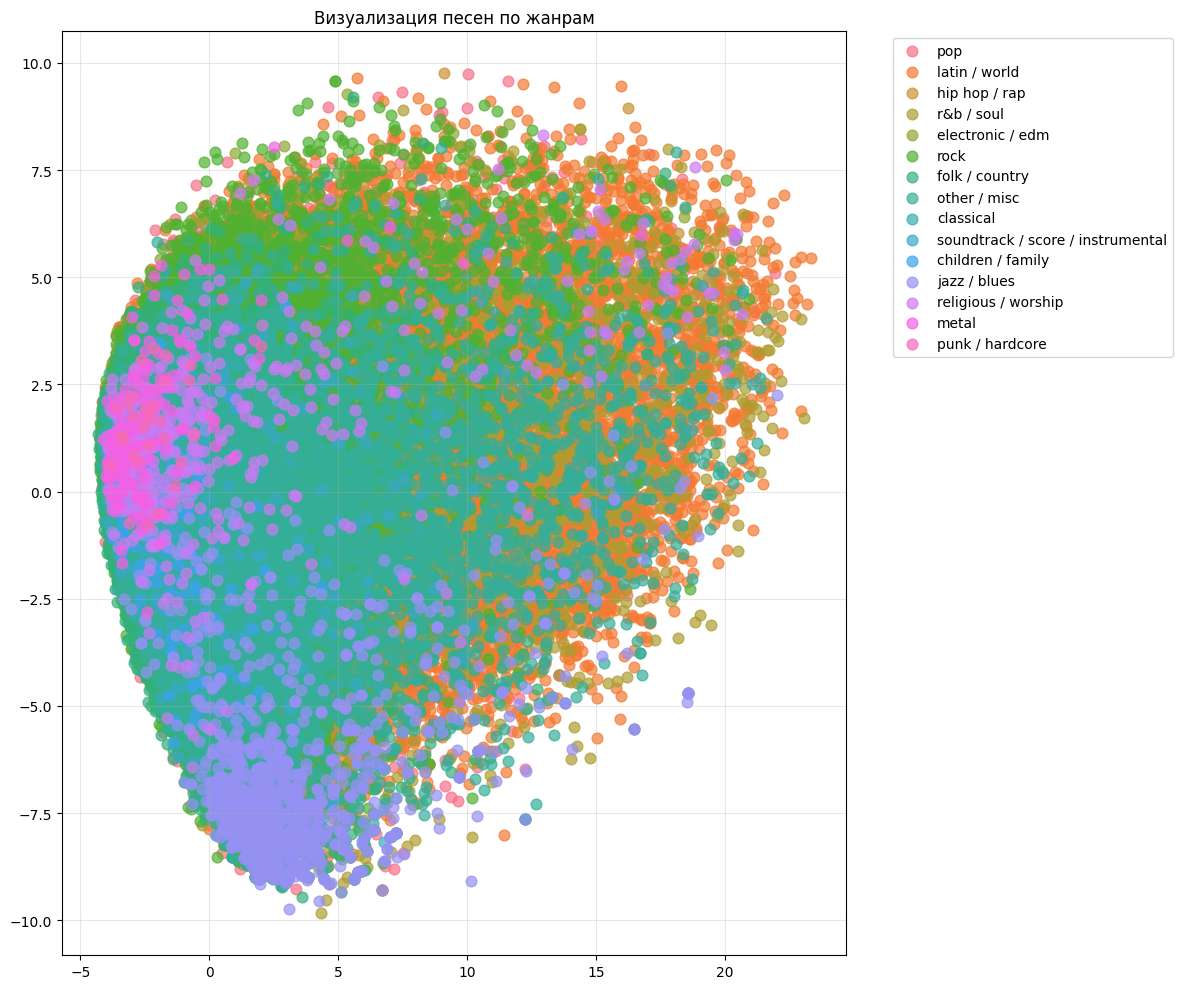

In [71]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Визуализация
plt.figure(figsize=(12, 10))
unique_genres = dataset.main_categories.unique()
palette = sns.color_palette('husl', n_colors=len(unique_genres))

for i, genre in enumerate(unique_genres):
    mask = (y == genre)
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1], 
        c=[palette[i]], 
        label=genre, 
        alpha=0.7,
        s=60
    )

plt.title('Визуализация песен по жанрам')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()